# Yelp Restaurant Recommendation - Final EDA Notebook

This notebook contains the final data loading, exploratory analysis, and preparation pipeline for a restaurant recommendation system using the Yelp dataset. All data files are stored in `.parquet` format under the `datasets/` folder.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
import branca
import urllib.request
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from collections import Counter
import plotly.express as px
import os
from PIL import Image
import numpy as np
import re
from wordcloud import WordCloud, STOPWORDS
# Set display options
pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')


## 2. Load Yelp Datasets

In [4]:
# Load business and review datasets
yelp_business = pd.read_parquet("datasets/yelp_business.parquet")
yelp_reviews = pd.read_parquet("datasets/yelp_reviews.parquet")

yelp_reviews_grouped = yelp_reviews.groupby("business_id")["text"].apply(list).reset_index()

yelp_review_counts = yelp_reviews.groupby("business_id").size().reset_index(name="n_reviews")

yelp = pd.merge(yelp_business, yelp_review_counts, on="business_id", how="left")
yelp = pd.merge(yelp, yelp_reviews_grouped, on="business_id", how="left")

yelp["n_reviews"] = yelp["n_reviews"].fillna(0).astype(int)
print("Total Restaurants:", yelp.shape[0])
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
yelp.head()


Total Restaurants: 51222


business_id                   name              address  \
0  MTSW4McQd7CbVtyjqoe9mw     St Honore Pastries          935 Race St   
1  CF33F8-E6oudUQ46HnavjQ         Sonic Drive-In        615 S Main St   
2  k0hlBqXX-Bt0vf1op7Jr1w  Tsevi's Pub And Grill    8025 Mackenzie Rd   
3  bBDDEgkFA1Otx9Lfe7BZUQ         Sonic Drive-In  2312 Dickerson Pike   
4  eEOYSgkmpB90uNA7lDOMRA  Vietnamese Food Truck                        

           city state postal_code   latitude  longitude  stars  review_count  \
0  Philadelphia    PA       19107  39.955505 -75.155564    4.0            80   
1  Ashland City    TN       37015  36.269593 -87.058943    2.0             6   
2        Affton    MO       63123  38.565165 -90.321087    3.0            19   
3     Nashville    TN       37207  36.208102 -86.768170    1.5            10   
4     Tampa Bay    FL       33602  27.955269 -82.456320    4.0            10   

                                          categories  \
0               [Bubble Tea, Coffee & Tea, Bakeries]   
1  [Burgers, Fast Food, Sandwiches, Ice Cream & F...   
2  [Pubs, Italian, Bars, American (Traditional), ...   
3    [Ice Cream & Frozen Yogurt, Fast Food, Burgers]   
4                          [Vietnamese, Food Trucks]   

                                     attributes_text  n_reviews  \
0  Street parking available | Bike parking availa...         87   
1  Delivery available | Outdoor seating available...          6   
2  Outdoor seating available | Accepts credit car...         19   
3  Delivery available | Outdoor seating available...         10   
4                                                            11   

                                                text  
0  [Rated 4.0 stars out of 5. This is nice little...  
1  [Rated 4.0 stars out of 5. I have always liked...  
2  [Rated 4.0 stars out of 5. I like Tsevis becau...  
3  [Rated 1.0 stars out of 5. Waited several minu...  
4  [Rated 5.0 stars out of 5. I eat pho about 4 t...

## 3. Least Common Categories and Their Most Frequent Cities

In [8]:
cat_counter = Counter()

for value in yelp['categories'].dropna():
    if isinstance(value, str):
        value = value.strip("[]").replace("'", "")
        cats = [c.strip().lower() for c in value.split(",") if c.strip()]
    elif isinstance(value, (list, tuple, np.ndarray)):
        cats = [str(c).strip().lower() for c in value if str(c).strip()]
    else:
        cats = []

    for cat in cats:
        cat_counter[cat] += 1

# Obtener las 10 menos comunes
least_common = sorted(cat_counter.items(), key=lambda x: x[1])[:10]
print("Least common categories:", least_common)

# Buscar ciudad y estado donde más aparece cada una
rows = []
for cat, count in least_common:
    mask = yelp['categories'].apply(
        lambda cats: isinstance(cats, (list, tuple, np.ndarray)) and cat in [str(c).lower() for c in cats]
        if not isinstance(cats, str)
        else cat in [c.strip().lower() for c in cats.strip("[]").replace("'", "").split(",")]
    )

    group = yelp[mask].groupby(['city', 'state']).size().reset_index(name='num_rest_cat')

    if not group.empty:
        top_row = group.loc[group['num_rest_cat'].idxmax()]
        rows.append({
            'Category': cat.title(),
            'Total Restaurants': count,
            'City': top_row['city'],
            'State': top_row['state'],
            'Restaurants in That City': top_row['num_rest_cat']
        })

# Mostrar resultados
df_least_common = pd.DataFrame(rows)
print("Shape:", df_least_common.shape)
df_least_common.head(10)


Least common categories: [('car dealers', 1), ('auto repair', 1), ('leisure centers', 1), ('appliances', 1), ('bike rentals', 1), ('travel services', 1), ('recreation centers', 1), ('fashion', 2), ('sporting goods', 2), ('mini golf', 3)]
Shape: (10, 5)


Category  Total Restaurants              City State  \
0         Car Dealers                  1       Talleyville    DE   
1         Auto Repair                  1         Langhorne    PA   
2     Leisure Centers                  1  Fairview Heights    IL   
3          Appliances                  1      Indianapolis    IN   
4        Bike Rentals                  1              Reno    NV   
5     Travel Services                  1         Nashville    TN   
6  Recreation Centers                  1      Philadelphia    PA   
7             Fashion                  2      Philadelphia    PA   
8      Sporting Goods                  2  Fairview Heights    IL   
9           Mini Golf                  3      Philadelphia    PA   

   Restaurants in That City  
0                         1  
1                         1  
2                         1  
3                         1  
4                         1  
5                         1  
6                         1  
7                         2  
8                         1  
9                         1

## 4. Exploratory Data Analysis (EDA)

### 6.1 Distribution of Restaurants by State

In [9]:
# Group by state
state_counts = yelp['state'].value_counts().reset_index()
state_counts.columns = ['State', 'Total Restaurants']

# Plot

fig = px.bar(state_counts.head(10), 
             x='State', 
             y='Total Restaurants',
             title='Top 10 States with Most Restaurants',
             color='State', 
             template='simple_white')
fig.show()

### 6.2 Distribution of restaurants by cities

In [ ]:
city_counts = yelp['city'].value_counts().reset_index()
city_counts.columns = ['City', 'Total Restaurants']

# Plot
fig = px.bar(city_counts.head(10), 
             x='City', 
             y='Total Restaurants',
             title='Top 10 Cities with Most Restaurants',
             color='City', 
             template='simple_white')
fig.show()

### 6.3 Most Common Restaurant Categories

In [20]:
# Flatten category list
all_cats = []

for value in yelp['categories'].dropna():
    if isinstance(value, str):
        value = value.strip("[]").replace("'", "")
        cats = [c.strip().lower() for c in value.split(",") if c.strip()]
    elif isinstance(value, (list, tuple, np.ndarray)):
        cats = [str(c).strip().lower() for c in value if str(c).strip()]
    else:
        cats = []
    
    all_cats.extend(cats)

# Contar frecuencia
cat_series = pd.Series(all_cats)
top_categories = cat_series.value_counts().head(10).reset_index()
top_categories.columns = ['Category', 'Count']

# Plot
fig = px.bar(top_categories, 
             x='Count', 
             y='Category',
             orientation='h', 
             title='Top 10 Most Common Categories',
             template='simple_white', 
             color='Category')

fig.update_layout(yaxis={'categoryorder': 'total ascending'})
fig.show()


### 6.4 Distribution of Star Ratings

In [21]:
fig = px.histogram(yelp, 
                   x='stars', 
                   nbins=10,
                   title='Distribution of Star Ratings',
                   template='simple_white')

fig.show()

### 6.5 Word Clouds by Rating

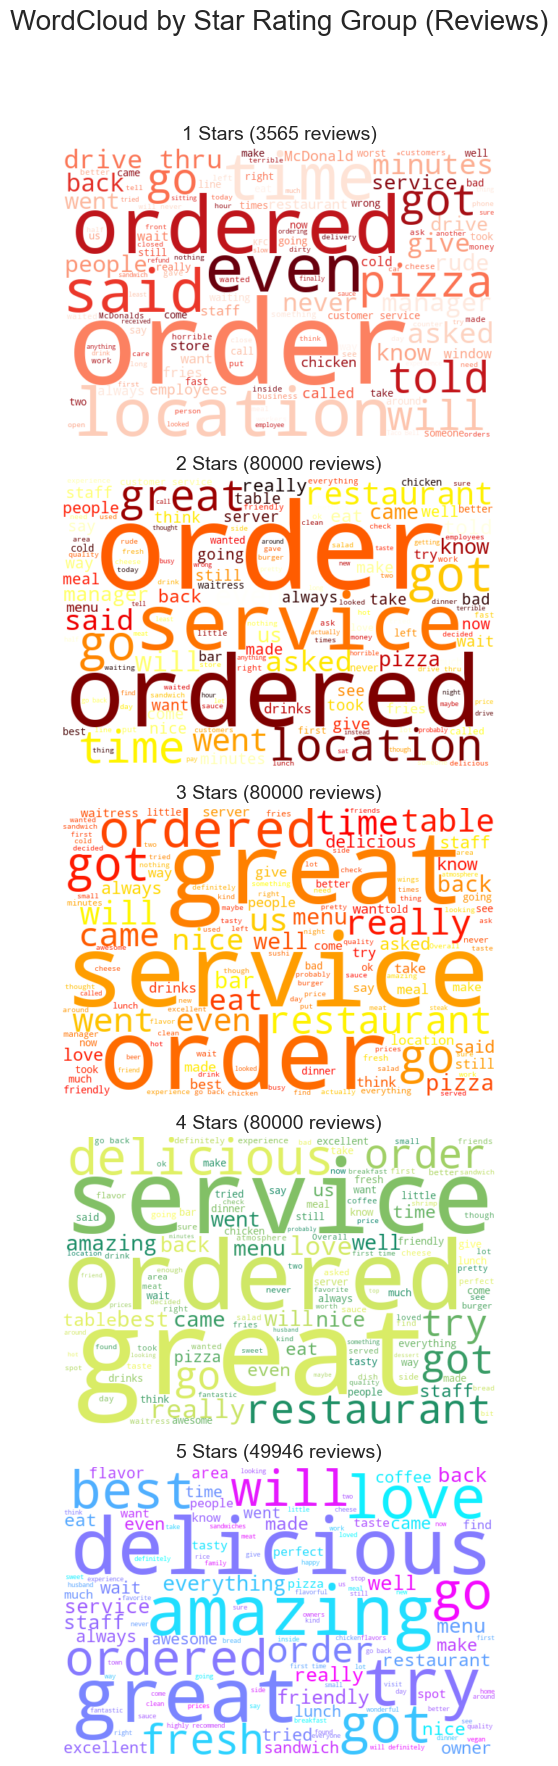

In [28]:
grupos = [1, 2, 3, 4, 5]

custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['rated', 'stars', 'out', 'of', '5', 'star', 'this', 'review', 'reviews', 'good', 'food','place','one'])

def clean_review_header(text):
    return re.sub(r"^Rated\s+\d(\.\d)?\s+stars\s+out\s+of\s+5\.\s*", "", str(text), flags=re.IGNORECASE)

if isinstance(yelp['text'].iloc[0], list):
    yelp_exploded = yelp.explode('text').copy()
else:
    yelp_exploded = yelp.copy()

yelp_exploded['text_clean'] = yelp_exploded['text'].apply(clean_review_header)

yelp_exploded['stars_group'] = yelp_exploded['stars'].round().astype(int)

colormaps = {
    1: 'Reds',
    2: 'hot',
    3: 'autumn',
    4: 'summer',
    5: 'cool'
}

fig, axes = plt.subplots(len(grupos), 1, figsize=(12, 18))
fig.suptitle("WordCloud by Star Rating Group (Reviews)", fontsize=20)
fig.patch.set_facecolor('white')

for i, estrellas in enumerate(grupos):
    subset = yelp_exploded[yelp_exploded['stars_group'] == estrellas]

  
    sample_size = min(80000, len(subset))
    textos = subset['text_clean'].sample(sample_size, random_state=42).astype(str).tolist()
    corpus = " ".join(textos)

    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        colormap=colormaps[estrellas],
        stopwords=custom_stopwords,
        max_words=200,
        min_font_size=8,
        prefer_horizontal=1.0,
        normalize_plurals=False
    ).generate(corpus)

    
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{estrellas} Stars ({sample_size} reviews)", fontsize=14)

    
    wc.to_file(f"wordcloud_{estrellas}stars.png")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### 6.6 Word Clouds by Categories

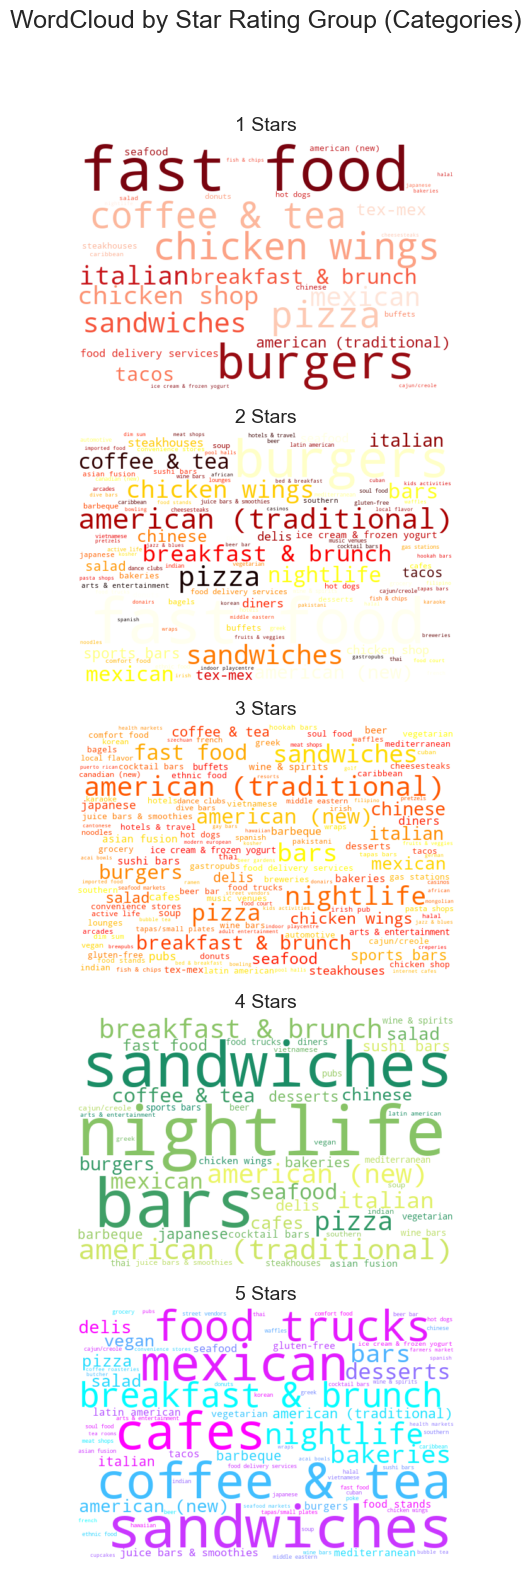

In [31]:
def to_category_list(x):
    if isinstance(x, str):
        x = x.strip("[]").replace("'", "")
        return [c.strip() for c in x.split(",") if c.strip()]
    elif isinstance(x, (list, tuple, np.ndarray)):
        return [str(c).strip() for c in x if str(c).strip()]
    else:
        return []

yelp['categories_list'] = yelp['categories'].apply(to_category_list)

# Agrupar por estrellas redondeadas
yelp['stars_group'] = yelp['stars'].round().astype(int)

# Grupos de estrellas que quieres mostrar
grupos = [1, 2, 3, 4, 5]

colormaps = {
    1: 'Reds',
    2: 'hot',
    3: 'autumn',
    4: 'summer',
    5: 'cool'
}

# Crear subplots
fig, axes = plt.subplots(len(grupos), 1, figsize=(10, 16))
fig.suptitle("WordCloud by Star Rating Group (Categories)", fontsize=18)

for i, estrellas in enumerate(grupos):
    subset = yelp[yelp['stars_group'] == estrellas]
    categorias = subset['categories_list'].dropna()

    # Contar categorías
    contador = Counter()
    for cat_list in categorias:
        for cat in cat_list:
            cat = cat.strip().lower()
            if cat and cat.isprintable():
                contador[cat] += 1

    # WordCloud con colormap
    wc = WordCloud(
        width=600, height=400,
        background_color='white',
        colormap=colormaps[estrellas],
        max_words=200,
        min_font_size=8,
        prefer_horizontal=1.0,
        normalize_plurals=False
    ).generate_from_frequencies(contador)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"{estrellas} Stars", fontsize=14)
    wc.to_file(f"wordcloud_{estrellas}categories.png")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



### 6.7 Most Common Restaurant Attributes

C:\Users\lucia\AppData\Local\Temp\ipykernel_10676\2820272324.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




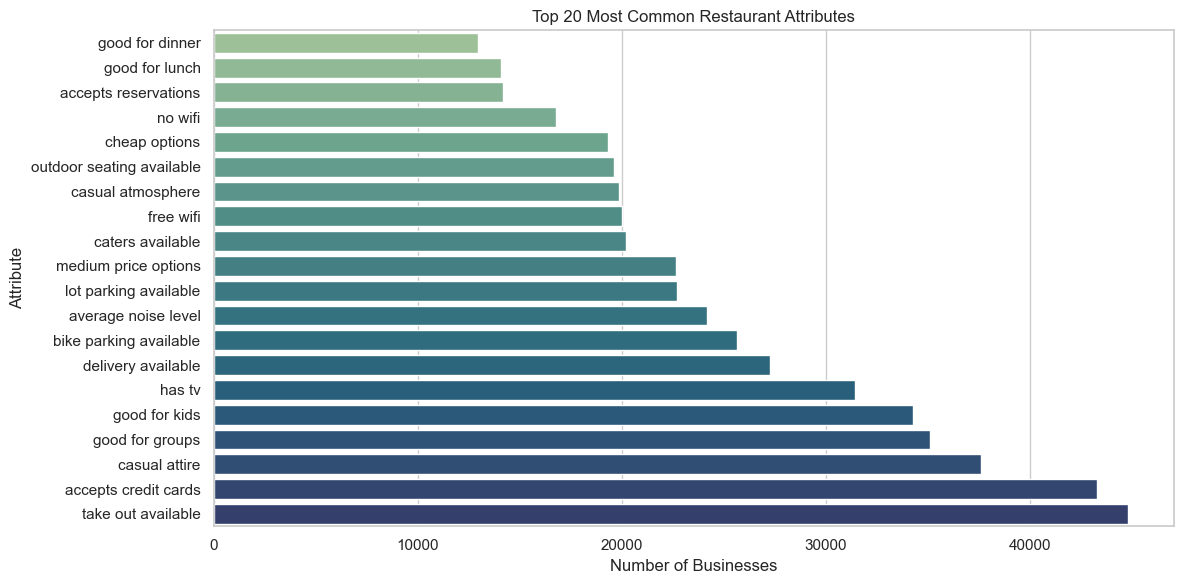

In [ ]:
all_attrs = []

for val in yelp['attributes_text'].dropna():
    items = [attr.strip().lower() for attr in val.split("|") if attr.strip()]
    all_attrs.extend(items)

# Contar frecuencia
attr_counter = Counter(all_attrs)
most_common = attr_counter.most_common(20)

# Convertir a DataFrame para plotear
df_top_attrs = pd.DataFrame(most_common, columns=["Attribute", "Count"]).sort_values("Count")

# Gráfico de barras horizontales
plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Attribute", data=df_top_attrs, palette="crest")
plt.title("Top 20 Most Common Restaurant Attributes")
plt.xlabel("Number of Businesses")
plt.ylabel("Attribute")
plt.tight_layout()
plt.show()

### 6.8 Least Common Restaurant Attribute

C:\Users\lucia\AppData\Local\Temp\ipykernel_7664\595193215.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




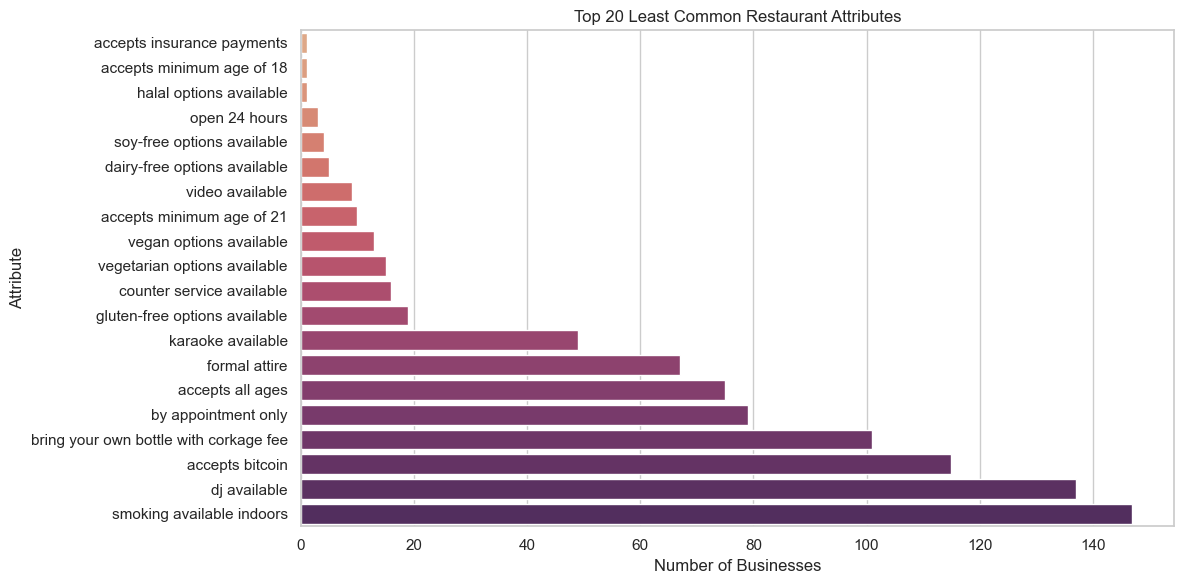

In [23]:

all_attrs = []

for val in yelp['attributes_text'].dropna():
    items = [attr.strip().lower() for attr in val.split("|") if attr.strip()]
    all_attrs.extend(items)

# Contar frecuencia y tomar los 20 menos comunes
attr_counter = Counter(all_attrs)
least_common = sorted(attr_counter.items(), key=lambda x: x[1])[:20]

# Convertir a DataFrame
df_least_attrs = pd.DataFrame(least_common, columns=["Attribute", "Count"]).sort_values("Count")

# Gráfico
plt.figure(figsize=(12, 6))
sns.barplot(x="Count", y="Attribute", data=df_least_attrs, palette="flare")
plt.title("Top 20 Least Common Restaurant Attributes")
plt.xlabel("Number of Businesses")
plt.ylabel("Attribute")
plt.tight_layout()
plt.show()

### 6.9 Relationship Between Average Rating and Number of Text Reviews

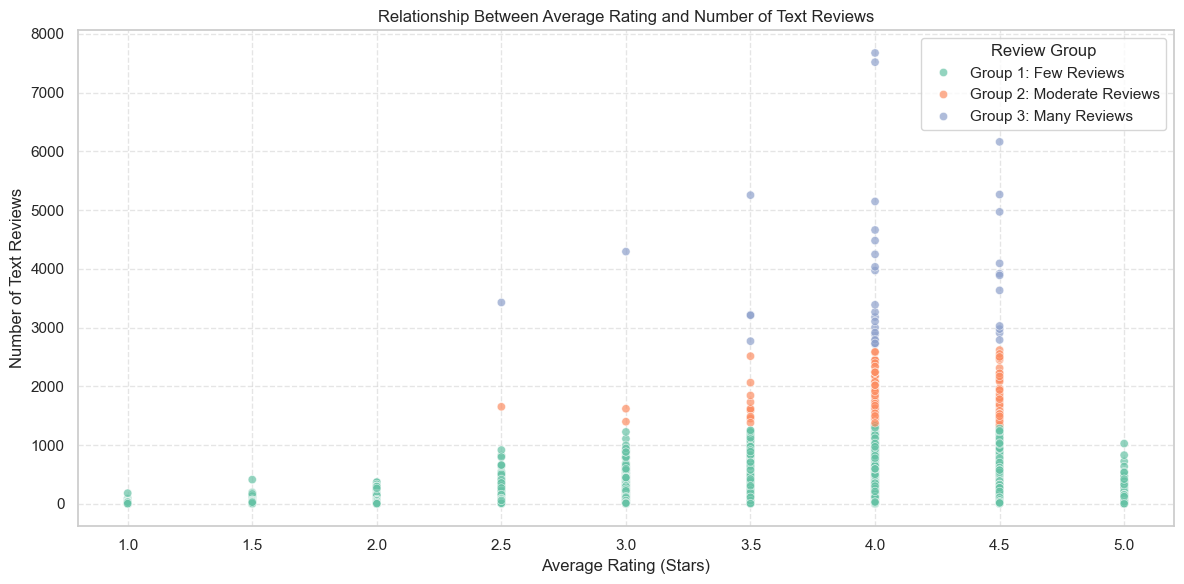

In [ ]:

yelp_with_reviews = yelp[yelp['n_reviews'] > 0].copy()

top10_most = yelp_with_reviews.sort_values('n_reviews', ascending=False).head(10)
top10_most['review_group'] = 'Most Reviews'

top10_least = yelp_with_reviews.sort_values('n_reviews', ascending=True).head(10)
top10_least['review_group'] = 'Fewest Reviews'

comparison = pd.concat([top10_most, top10_least])

yelp_with_reviews['review_group'] = pd.cut(
    yelp_with_reviews['n_reviews'],
    bins=[0, 1333, 2666, 8000],
    labels=[
        'Group 1: Few Reviews',
        'Group 2: Moderate Reviews',
        'Group 3: Many Reviews'
    ]
)

scatter_data = yelp_with_reviews[yelp_with_reviews['review_group'].notna()]

plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=scatter_data,
    x='stars',
    y='n_reviews',
    hue='review_group',
    palette='Set2',
    alpha=0.7
)

plt.title("Relationship Between Average Rating and Number of Text Reviews")
plt.xlabel("Average Rating (Stars)")
plt.ylabel("Number of Text Reviews")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Review Group")
plt.tight_layout()
plt.show()

### 6.10 Interactive Map: Most Common Category per State

In [10]:
geojson_url = "https://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json"
urllib.request.urlretrieve(geojson_url, "us-states.json")

with open("us-states.json") as f:
    geojson_data = json.load(f)

us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

In [17]:
def to_category_list(value):
    if isinstance(value, str):
        value = value.strip("[]").replace("'", "")
        return [c.strip().lower() for c in value.split(",") if c.strip()]
    elif isinstance(value, (list, tuple, np.ndarray)):
        return [str(c).strip().lower() for c in value if str(c).strip()]
    else:
        return []

yelp['categories_list'] = yelp['categories'].apply(to_category_list)


In [19]:
# Agrupar por estado y obtener la categoría más común
df_top_cat_estado = yelp.groupby('state').agg({
    'categories_list': lambda x: pd.Series([i for sublist in x for i in sublist]).mode().iloc[0]
    if len(x) > 0 and not pd.Series([i for sublist in x for i in sublist]).mode().empty
    else None,
    'business_id': 'count'
}).reset_index().rename(columns={
    'business_id': 'n_restaurantes',
    'categories_list': 'Most Common Category'
})

df_top_cat_estado['Full State Name'] = df_top_cat_estado['state'].map(us_state_abbrev)
df_top_cat_estado = df_top_cat_estado.dropna(subset=['Full State Name'])

estado_categoria = dict(zip(df_top_cat_estado['Full State Name'], df_top_cat_estado['Most Common Category']))
estado_recuento = dict(zip(df_top_cat_estado['Full State Name'], df_top_cat_estado['n_restaurantes']))

categorias_unicas = list(set(estado_categoria.values()))
cmap = cm.get_cmap("tab20", len(categorias_unicas))
color_por_categoria = {cat: mcolors.to_hex(cmap(i)) for i, cat in enumerate(categorias_unicas)}

mapa = folium.Map(location=[37.8, -96], zoom_start=4, tiles="CartoDB positron")

for feature in geojson_data['features']:
    estado = feature['properties']['NAME']
    categoria = estado_categoria.get(estado)
    recuento = estado_recuento.get(estado)
    color = color_por_categoria.get(categoria, '#ffffff')
    tooltip = f"{estado}: {categoria}, {recuento} restaurants" if categoria else estado
    folium.GeoJson(
        feature,
        style_function=lambda feat, col=color: {
            'fillColor': col,
            'color': 'gray',
            'weight': 1,
            'fillOpacity': 0.7
        },
        tooltip=folium.Tooltip(tooltip)
    ).add_to(mapa)

legend_html = "<div style='position: fixed; bottom: 40px; left: 40px; width: 250px; height: auto; background-color: white; z-index:9999; font-size:14px; border:1px solid grey; padding: 10px'><b>Most Common Category by State</b><br>" + "".join(
    f"<div style='margin:4px'><span style='display:inline-block;width:12px;height:12px;background-color:{color_por_categoria[cat]};margin-right:6px;'></span>{cat}</div>"
    for cat in categorias_unicas) + "</div>"

mapa.get_root().html.add_child(folium.Element(legend_html))
mapa


C:\Users\lucia\AppData\Local\Temp\ipykernel_7664\152617752.py:19: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



### 6.11 Histogram of Average Review Length

In [25]:
# Calcular cantidad de reseñas por restaurante
yelp['n_reviews'] = yelp['text'].apply(lambda x: len(x) if isinstance(x, list) else 0)

# Calcular longitud total de texto
yelp['total_length'] = yelp['text'].apply(lambda lst: sum(len(str(r)) for r in lst) if isinstance(lst, list) else 0)

# Longitud promedio por reseña
yelp['avg_review_length'] = yelp['total_length'] / yelp['n_reviews'].replace(0, 1)  # evitar división por cero

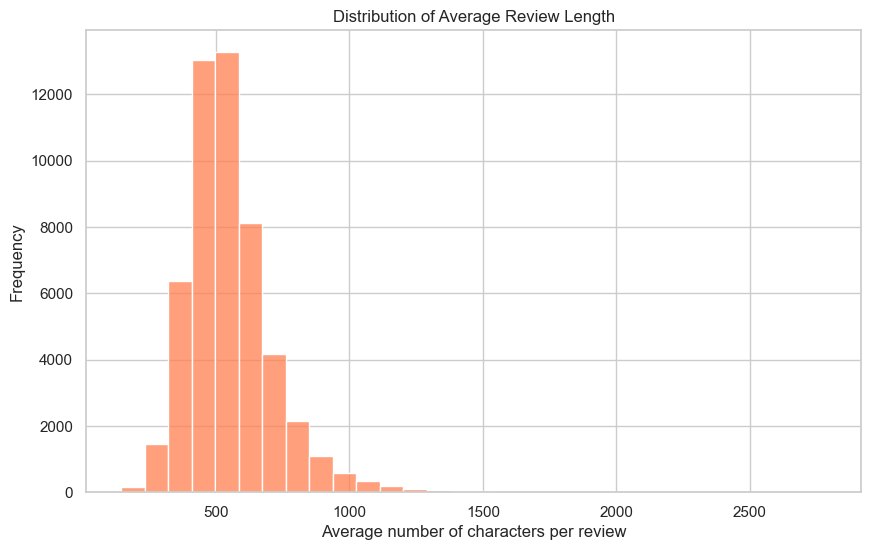

In [26]:
sns.histplot(yelp['avg_review_length'], bins=30, color='coral')
plt.title("Distribution of Average Review Length")
plt.xlabel("Average number of characters per review")
plt.ylabel("Frequency")
plt.show()

### 6.12 Numerical Summary

In [27]:
num_categories = len(set(cat for cats in yelp['categories_list'] for cat in cats))

# Unique attributes from 'attributes_text'
all_attrs = []
for val in yelp['attributes_text'].dropna():
    all_attrs.extend([attr.strip().lower() for attr in val.split("|") if attr.strip()])
num_attributes = len(set(all_attrs))

# Build summary table
summary_df = pd.DataFrame({
    "Metric": [
        "Total number of restaurants",
        "Number of US states represented",
        "Number of unique cities",
        "Average star rating",
        "Median star rating",
        "Total number of text reviews",
        "Average number of reviews per restaurant",
        "Median number of reviews per restaurant",
        "Average review length (characters)",
        "Median review length (characters)",
        "Number of unique categories",
        "Number of unique attributes"
    ],
    "Value": [
        yelp.shape[0],
        yelp['state'].nunique(),
        yelp['city'].nunique(),
        round(yelp['stars'].mean(), 2),
        round(yelp['stars'].median(), 2),
        int(yelp['n_reviews'].sum()),
        round(yelp['n_reviews'].mean(), 2),
        round(yelp['n_reviews'].median(), 2),
        round(yelp['avg_review_length'].mean(), 1),
        round(yelp['avg_review_length'].median(), 1),
        num_categories,
        num_attributes
    ]
})

summary_df

Metric       Value
0                Total number of restaurants    51222.00
1            Number of US states represented       18.00
2                    Number of unique cities      913.00
3                        Average star rating        3.51
4                         Median star rating        3.50
5               Total number of text reviews  4629668.00
6   Average number of reviews per restaurant       90.38
7    Median number of reviews per restaurant       35.00
8         Average review length (characters)      551.30
9          Median review length (characters)      526.20
10               Number of unique categories      296.00
11               Number of unique attributes       86.00